In [30]:
from keras import layers
import numpy as np
import tensorflow as tf
import cv2
import glob
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.callbacks import TensorBoard
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout, UpSampling2D
from keras.models import Model
from tqdm import tqdm
from keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16
import os

In [2]:
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_original/*.png' )
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_mask/*.png')
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train/*.png')
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train_mask/*.png')

In [3]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [4]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    HueSaturationValue,
    RGBShift,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    GaussNoise,
    ChannelShuffle,
    CoarseDropout
)

In [5]:
def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

In [6]:
def augment_data(images, masks, save_path, augment=True):
    """ Performing data augmentation. """
    # crop_size = (192-32, 256-32)
    # size = (256, 192)
    crop_size = (128-32, 128-32)
    size = (96, 96)


    for image, mask in tqdm(zip(images, masks), total=len(images)):
        image_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]

        x, y = read_data(image, mask)
        try:
            h, w, c = x.shape
        except Exception as e:
            image = image[:-1]
            x, y = read_data(image, mask)
            h, w, c = x.shape

        if augment == True:
            ## Center Crop
            
            if crop_size[0] <= h and crop_size[1] <= w:
                # Center Crop
                aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
                augmented = aug(image=x, mask=y)
                x1 = augmented['image']
                y1 = augmented['mask']

                # Crop
                x_min = 0
                y_min = 0
                x_max = x_min + size[0]
                y_max = y_min + size[1]

                aug = Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
                augmented = aug(image=x, mask=y)
                x2 = augmented['image']
                y2 = augmented['mask']
 
    
                ## Random Rotate 90 degree
                aug = RandomRotate90(p=1)
                augmented = aug(image=x, mask=y)
                x3 = augmented['image']
                y3 = augmented['mask']
    
                ## Transpose
                aug = Transpose(p=1)
                augmented = aug(image=x, mask=y)
                x4 = augmented['image']
                y4 = augmented['mask']
    
                ## ElasticTransform
                aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
                augmented = aug(image=x, mask=y)
                x5 = augmented['image']
                y5 = augmented['mask']
    
                ## Grid Distortion
                aug = GridDistortion(p=1)
                augmented = aug(image=x, mask=y)
                x6 = augmented['image']
                y6 = augmented['mask']
    
                ## Optical Distortion
                aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
                augmented = aug(image=x, mask=y)
                x7 = augmented['image']
                y7 = augmented['mask']
    
                ## Vertical Flip
                aug = VerticalFlip(p=1)
                augmented = aug(image=x, mask=y)
                x8 = augmented['image']
                y8 = augmented['mask']
    
                ## Horizontal Flip
                aug = HorizontalFlip(p=1)
                augmented = aug(image=x, mask=y)
                x9 = augmented['image']
                y9 = augmented['mask']
    
                ## Grayscale
                x10 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
                y10 = y
    
                ## Grayscale Vertical Flip
                aug = VerticalFlip(p=1)
                augmented = aug(image=x10, mask=y10)
                x11 = augmented['image']
                y11 = augmented['mask']
    
                ## Grayscale Horizontal Flip
                aug = HorizontalFlip(p=1)
                augmented = aug(image=x10, mask=y10)
                x12 = augmented['image']
                y12 = augmented['mask']
    
                ## Grayscale Center Crop
                aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
                augmented = aug(image=x10, mask=y10)
                x13 = augmented['image']
                y13 = augmented['mask']
    
                ##
                aug = RandomBrightnessContrast(p=1)
                augmented = aug(image=x, mask=y)
                x14 = augmented['image']
                y14 = augmented['mask']
    
                aug = RandomGamma(p=1)
                augmented = aug(image=x, mask=y)
                x15 = augmented['image']
                y15 = augmented['mask']
    
                aug = HueSaturationValue(p=1)
                augmented = aug(image=x, mask=y)
                x16 = augmented['image']
                y16 = augmented['mask']
    
                aug = RGBShift(p=1)
                augmented = aug(image=x, mask=y)
                x17 = augmented['image']
                y17 = augmented['mask']
    
                aug = RandomBrightness(p=1)
                augmented = aug(image=x, mask=y)
                x18 = augmented['image']
                y18 = augmented['mask']
    
                aug = RandomContrast(p=1)
                augmented = aug(image=x, mask=y)
                x19 = augmented['image']
                y19 = augmented['mask']
    
                aug = MotionBlur(p=1, blur_limit=7)
                augmented = aug(image=x, mask=y)
                x20 = augmented['image']
                y20 = augmented['mask']
    
                aug = MedianBlur(p=1, blur_limit=(3, 9))
                augmented = aug(image=x, mask=y)
                x21 = augmented['image']
                y21 = augmented['mask']
    
    
                aug = GaussianBlur(p=1, blur_limit=(3, 9))
                augmented = aug(image=x, mask=y)
                x22 = augmented['image']
                y22 = augmented['mask']
    
                aug = GaussNoise(p=1)
                augmented = aug(image=x, mask=y)
                x23 = augmented['image']
                y23 = augmented['mask']
    
                aug = ChannelShuffle(p=1)
                augmented = aug(image=x, mask=y)
                x24 = augmented['image']
                y24 = augmented['mask']
    
                aug = CoarseDropout(p=1, max_holes=8, max_height=32, max_width=32)
                augmented = aug(image=x, mask=y)
                x25 = augmented['image']
                y25 = augmented['mask']
    
                images = [
                    x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
                    x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,
                    x21, x22, x23, x24, x25
                ]
                masks  = [
                    y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10,
                    y11, y12, y13, y14, y15, y16, y17, y18, y19, y20,
                    y21, y22, y23, y24, y25
                ]
            else: 
                print(f"Skipping augmentation for {image_name} due to insufficient dimensions.")

        else:
            images = [x]
            masks  = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name  = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

In [7]:
from glob import glob

# def get_skin_lesion_data(path, split=0.1):
#     train_x = glob(os.path.join(path, '/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train/*.png'))
#     train_y = glob(os.path.join(path, '/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train_mask/*.png'))
# 
#     return (train_x, train_y)


def get_skin_lesion_data(path, split=0.1):
    train_x = glob(os.path.join(path, '/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/'
                                  'Dataset_BUSI_with_GT/breast_train/*.png'))
    train_y = glob(os.path.join(path, '/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/random_walk_breast_128_SEEDS_small_dataset/*.png'))

    return (train_x, train_y)

In [8]:
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

In [9]:
np.random.seed(42)
path = "/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT"
(train_x, train_y) = get_skin_lesion_data(path, split=0.1)

# create_dir("new_data_breast/train/image/")
# create_dir("new_data_breast/train/mask/")
create_dir("new_data_breast_rw_SEEDS/train/image/")
create_dir("new_data_breast_rw_SEEDS/train/mask/")

augment_data(train_x, train_y, "new_data_breast_rw_SEEDS/train/", augment=True)



  0%|          | 0/555 [00:00<?, ?it/s]/home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
100%|██████████| 555/555 [01:12<00:00,  7.67it/s]


In [96]:
import os
folder_path = '/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast/train/mask'
import glob as glob

# Use glob to get a list of files in the folder
file_list = glob.glob(os.path.join(folder_path, '*'))

# Use len to get the number of files
num_images = len(file_list)

print(f"Number of images in the folder: {num_images}")

Number of images in the folder: 12948


In [4]:
image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast/train/image/*.jpg')
mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast/train/mask/*.jpg')

In [5]:
batch_size = 8
threshold_value = 128
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                img = cv2.resize(img, (128, 128))

                mask = cv2.imread(mask_path,0)
                mask = cv2.resize(mask, (128, 128))


                # normalize the image and mask to have values between 0 and 1
                img = img / 255.0
                mask= mask/ 255.0


                batch_images.append(img)
                batch_masks.append(mask)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)


            yield batch_images, batch_masks
# #
# generator = data_generator(image_paths, mask_paths, 1)
# 
# for _,imgpath in tqdm(enumerate(image_paths)):
#    batch = next(generator)


In [6]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

In [7]:
def precision(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_flat, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

In [8]:
def sensitivity(gt_mask, pred_mask):

    gt_mask_flat = K.flatten(gt_mask)
    pred_mask_flat = K.flatten(pred_mask)

    # compute true positive (TP) and false negative (FN) counts
    TP = K.sum(gt_mask_flat * pred_mask_flat)
    FN = K.sum(gt_mask_flat * (1 - pred_mask_flat))

    # compute sensitivity (recall)
    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [10]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred,1)

In [11]:
assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=2023
)

# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)

1294
323


In [12]:
from keras.applications import MobileNetV2

IMAGE_SIZE = 128
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(n_filters=16, batchnorm=True, dropout=0.1, num_classes=1):
    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = tf.keras.utils.get_file(model_name, weight_path)

    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output

    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides=(2, 2), padding='same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size=3, batchnorm=batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size=3, batchnorm=batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides=(2, 2), padding='same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size=3, batchnorm=batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size=3, batchnorm=batchnorm)

    # Output layer with sigmoid activation for binary segmentation
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [13]:
def build_unet_with_pretrained_vgg16(input_size=(128, 128, 3)):
    # Load pre-trained VGG16 without the fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_size)

    # Extract skip connections from VGG16
    skip_connections = [base_model.get_layer(name).output for name in ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']]

    # Encoder (VGG16)
    inputs = Input(shape=input_size, name='input')
    x = base_model(inputs)

    # Decoder
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip_connections[3]], axis=-1)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip_connections[2]], axis=-1)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip_connections[1]], axis=-1)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip_connections[0]], axis=-1)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs, name='unet_with_vgg16')
    return model

In [14]:

def build_unet(input_size=(128,128,3)):

    inputs  = Input(input_size)

    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool5)
    conv6 = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)


    up7 = layers.concatenate([Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(conv6), conv5], axis=3)


    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)


    up8 = layers.concatenate([Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv7), conv4], axis=3)

    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv8), conv3], axis=3)

    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

    up10 = layers.concatenate([Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv9), conv2], axis=3)

    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    up11 = layers.concatenate([Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv10), conv1], axis=3)

    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)

    conv12 = Conv2D(1, (1,1), activation='sigmoid')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])

In [42]:
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'


In [43]:
weight_path = "{}_full_pixel_unet_breast.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat, tbcallback]

2024-02-06 11:48:26.426243: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-02-06 11:48:26.426285: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2024-02-06 11:48:26.426651: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:133] cuptiGetTimestamp: ignored due to a previous error.
2024-02-06 11:48:26.426707: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:184] cuptiSubscribe: ignored due to a previous error.
2024-02-06 11:48:26.426719: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:457] cuptiGetResultString: ignored due to a previous error.
2024-02-06 11:48:26.426730: E tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1715] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-02-06 11:48:26.426784: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-02-06 11:48:26.

In [19]:
# model =build_unet(input_size=(128,128,3))
model =unet(n_filters=16, batchnorm=True, dropout=0.1, num_classes=1)
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics= [dice_coef, precision, sensitivity, iou],  run_eagerly=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [18]:
loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)

model.save("full_pixel_unet_breast.h5")

Number of images: 10358
Number of masks: 10358
Epoch 1/50


/tmp/ipykernel_150021/2732983490.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = model.fit_generator(
2024-01-26 21:46:38.280160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-01-26 21:46:39.124076: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-26 21:46:39.126392: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-01-26 21:46:39.126422: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
20

2024-01-26 21:46:42.217953: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


2024-01-26 21:46:42.556004: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-26 21:46:42.657640: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-26 21:46:42.866372: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

   1/1294 [..............................] - ETA: 7:52:32 - loss: 0.8072 - dice_coef: 0.1928 - precision: 0.1167 - sensitivity: 0.4780 - iou: 0.1067

2024-01-26 21:46:58.300243: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-26 21:46:58.300275: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


   2/1294 [..............................] - ETA: 27:44 - loss: 0.8167 - dice_coef: 0.1833 - precision: 0.1096 - sensitivity: 0.4843 - iou: 0.1009  

2024-01-26 21:46:59.447951: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2024-01-26 21:46:59.479742: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2024-01-26 21:46:59.550060: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 1645 callback api events and 1742 activity events. 
2024-01-26 21:46:59.568341: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-26 21:46:59.576426: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board/plugins/profile/2024_01_26_21_46_59/somayeh-ASUS-TUF-Gaming-F15-FX506HCB-FX506HCB.xplane.pb


1294/1294 [==============================] - ETA: 0s - loss: 0.2979 - dice_coef: 0.7021 - precision: 0.7342 - sensitivity: 0.7399 - iou: 0.5599Number of images: 2590
Number of masks: 2590

Epoch 1: val_loss improved from inf to 0.32658, saving model to cxr_reg_full_pixel_unet_breast.best.hdf5
1294/1294 [==============================] - 389s 284ms/step - loss: 0.2979 - dice_coef: 0.7021 - precision: 0.7342 - sensitivity: 0.7399 - iou: 0.5599 - val_loss: 0.3266 - val_dice_coef: 0.6734 - val_precision: 0.8496 - val_sensitivity: 0.5874 - val_iou: 0.5250 - lr: 1.0000e-04
Epoch 2/50


2024-01-26 21:53:05.813072: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-26 21:53:05.813139: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-26 21:53:07.087798: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-26 21:53:07.087838: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

1294/1294 [==============================] - ETA: 0s - loss: 0.1894 - dice_coef: 0.8106 - precision: 0.8480 - sensitivity: 0.8031 - iou: 0.6919
Epoch 2: val_loss improved from 0.32658 to 0.30060, saving model to cxr_reg_full_pixel_unet_breast.best.hdf5
1294/1294 [==============================] - 368s 283ms/step - loss: 0.1894 - dice_coef: 0.8106 - precision: 0.8480 - sensitivity: 0.8031 - iou: 0.6919 - val_loss: 0.3006 - val_dice_coef: 0.6994 - val_precision: 0.9222 - val_sensitivity: 0.5857 - val_iou: 0.5545 - lr: 1.0000e-04
Epoch 3/50
1294/1294 [==============================] - ETA: 0s - loss: 0.1586 - dice_coef: 0.8415 - precision: 0.8768 - sensitivity: 0.8272 - iou: 0.7355
Epoch 3: val_loss improved from 0.30060 to 0.20561, saving model to cxr_reg_full_pixel_unet_breast.best.hdf5
1294/1294 [==============================] - 365s 282ms/step - loss: 0.1586 - dice_coef: 0.8415 - precision: 0.8768 - sensitivity: 0.8272 - iou: 0.7355 - val_loss: 0.2056 - val_dice_coef: 0.7944 - val_pr

In [19]:
from tensorflow.keras.models import load_model

model = load_model("full_pixel_unet_chest.h5", custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef, 'precision': precision, 'sensitivity': sensitivity, 'iou': iou})


In [20]:
model.load_weights("{}_full_pixel_unet_chest.best.hdf5".format('cxr_reg'))

In [24]:
test_images = []
ground_truth_test_images = []

test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_original/*.png")
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_mask/*.png")
# test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test/*.png")
# test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test_mask/*.png")

(70, 128, 128, 3)
(70, 128, 128)


2024-02-06 12:02:53.041032: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-06 12:02:53.041079: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-06 12:02:53.067461: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-06 12:02:53.067528: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

70/70 [==============================] - 3s 30ms/step
(70, 128, 128, 1)
(70, 128, 128, 1)
(70, 128, 128)
Dices: [<tf.Tensor: shape=(), dtype=float64, numpy=0.981754564275158>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9543689528764348>, <tf.Tensor: shape=(), dtype=float64, numpy=0.8972178923235448>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9726994315496612>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9281649948968052>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9620642091130505>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9373298967765453>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9635299322322554>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9615252536897541>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9692441594646303>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9550605302595587>, <tf.Tensor: shape=(), dtype=float64, numpy=0.924145948247406>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9605094149165059>, <tf.Tensor: shape=(), dtype=float64, numpy=0.939548003584

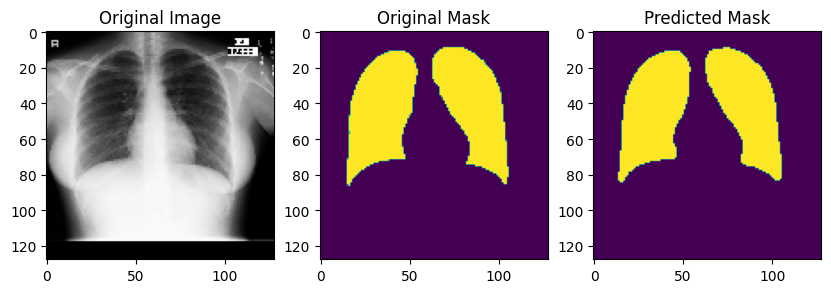

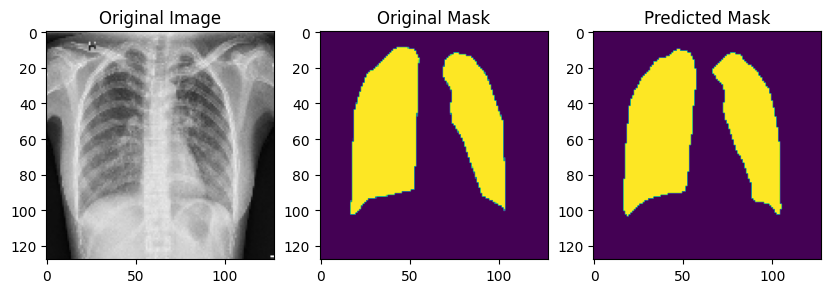

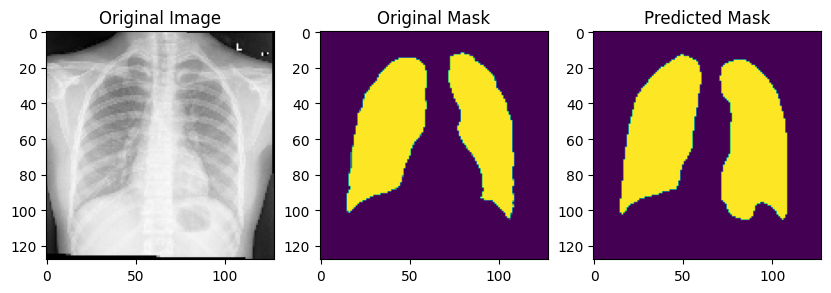

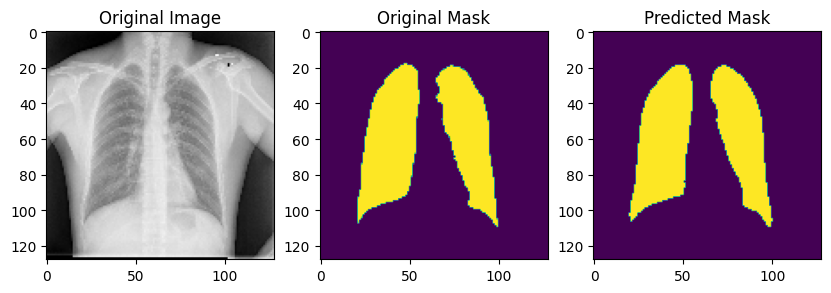

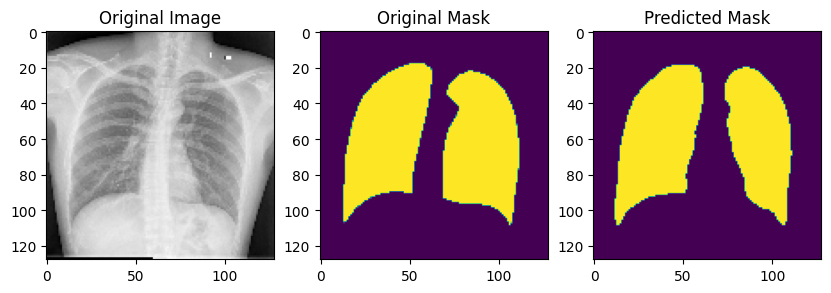

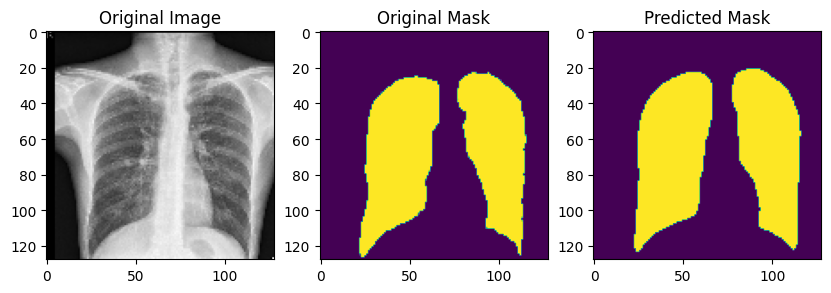

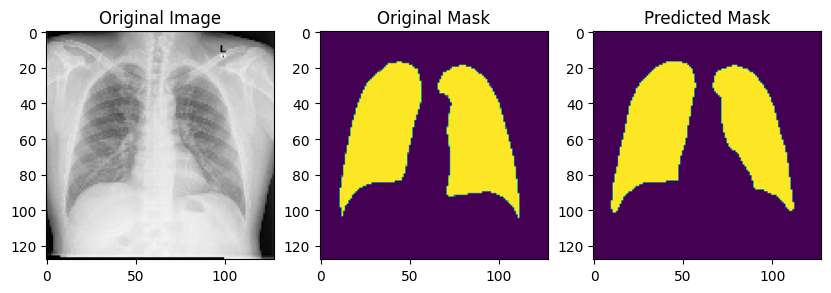

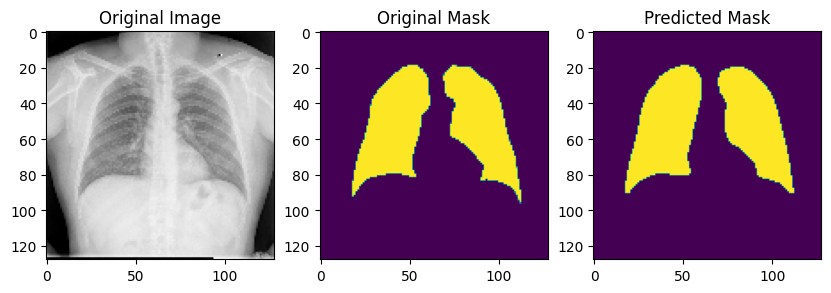

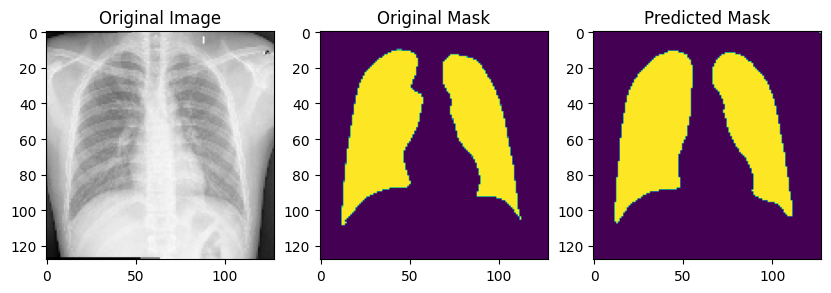

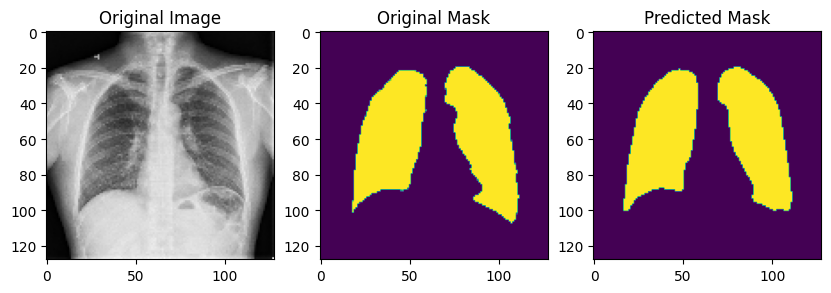

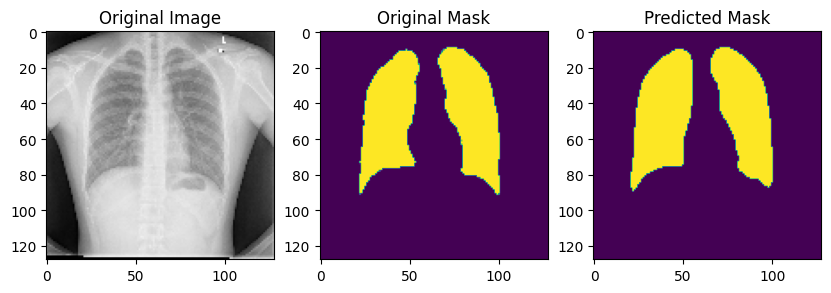

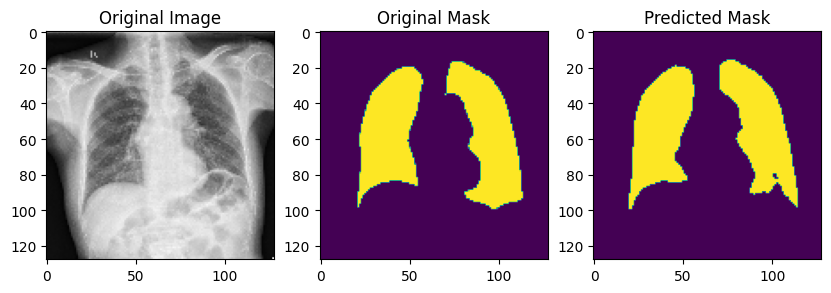

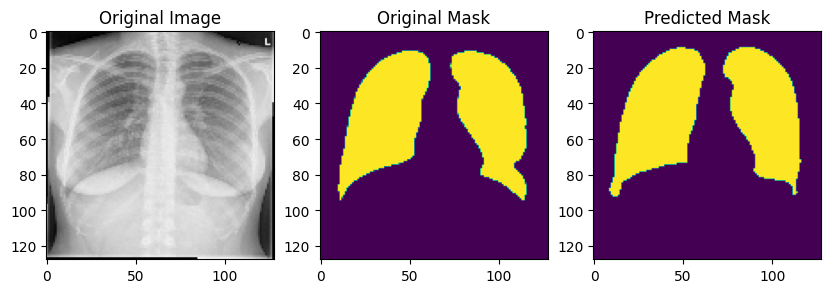

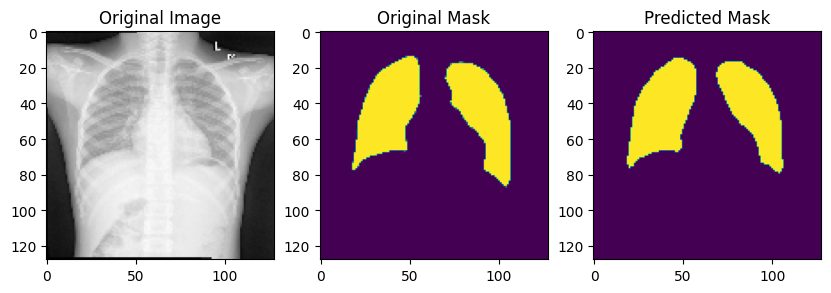

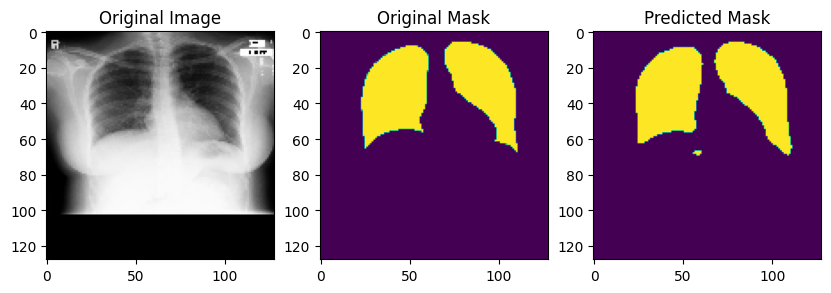

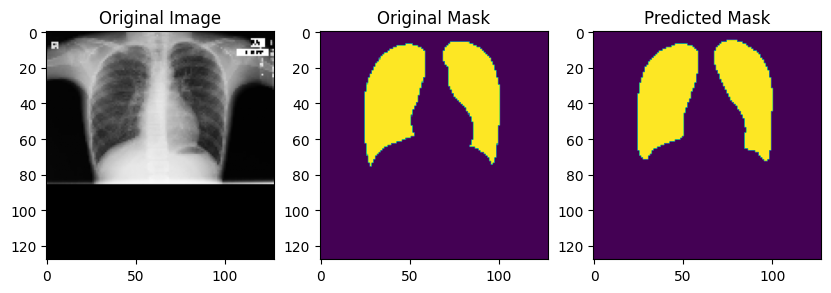

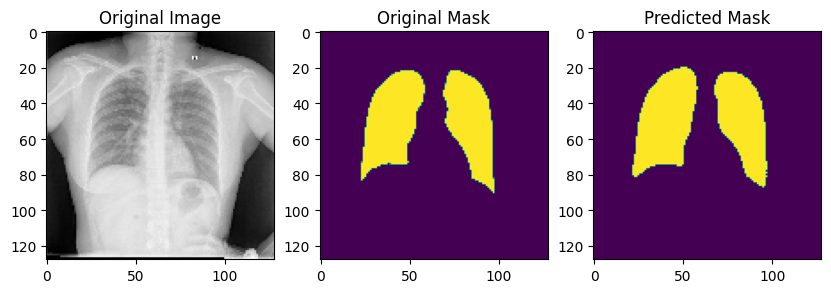

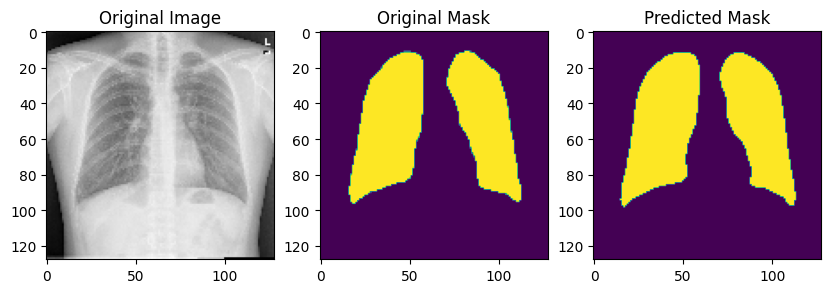

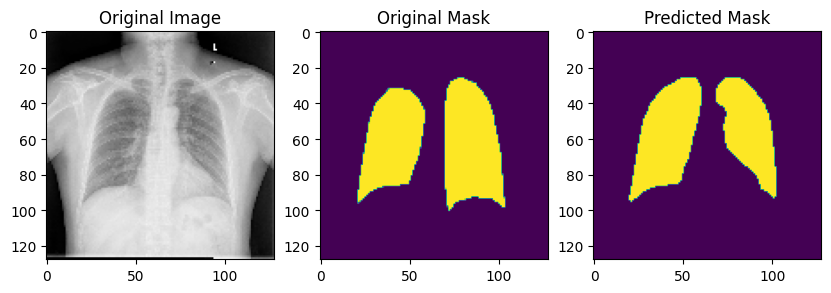

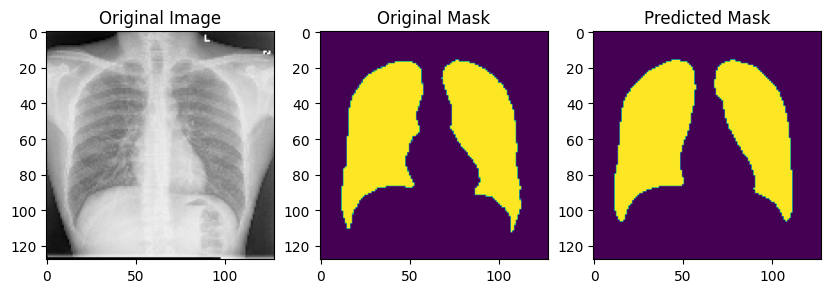

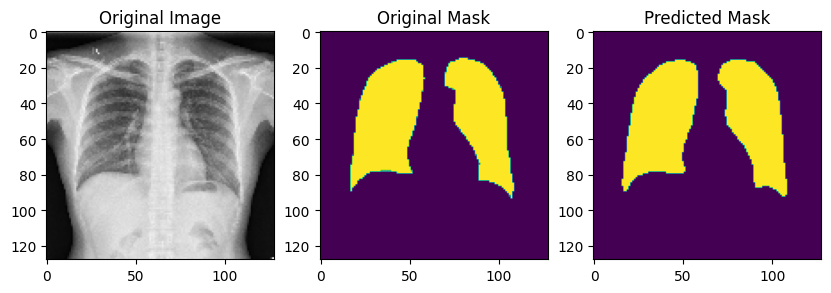

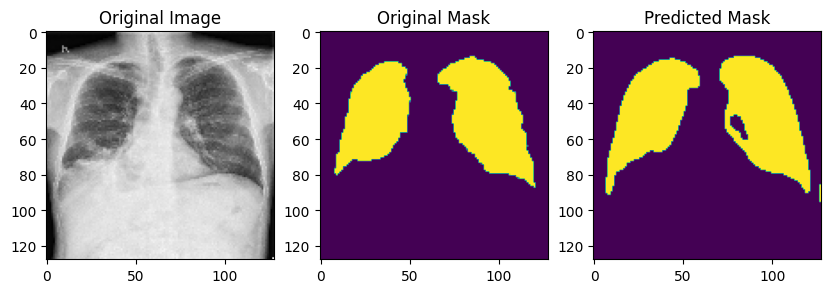

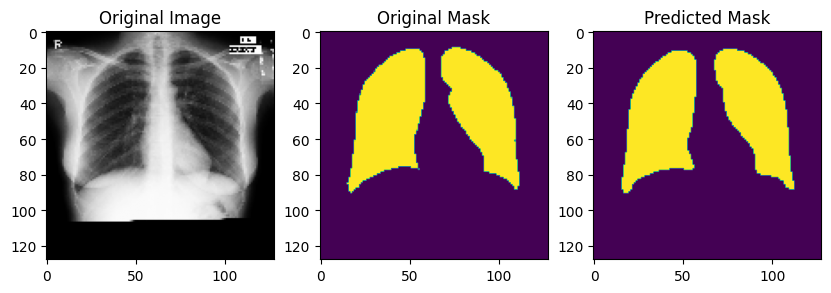

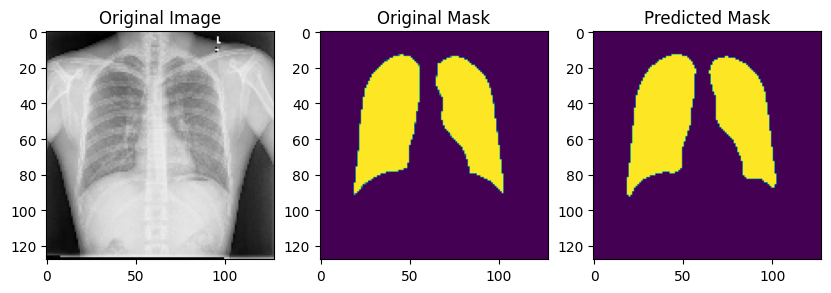

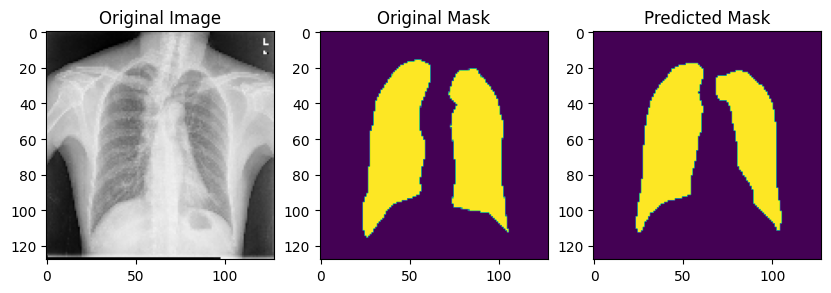

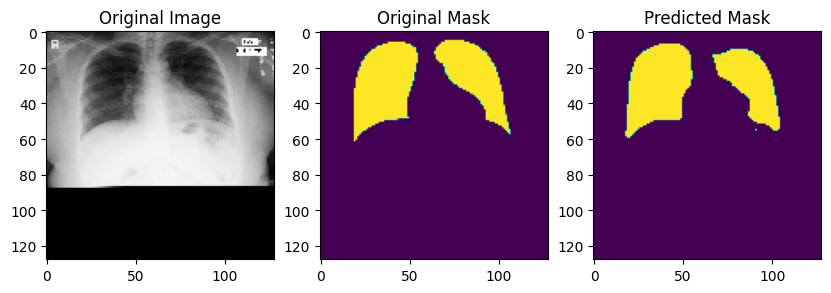

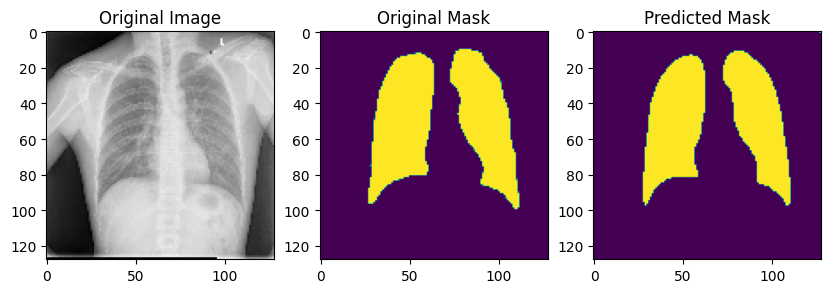

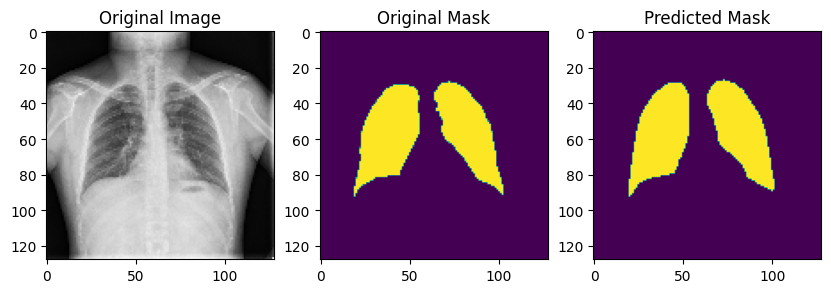

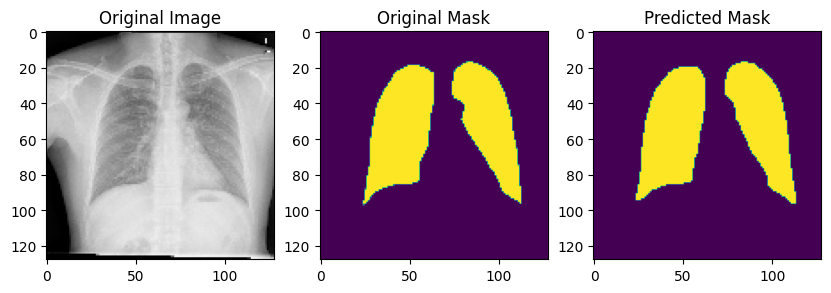

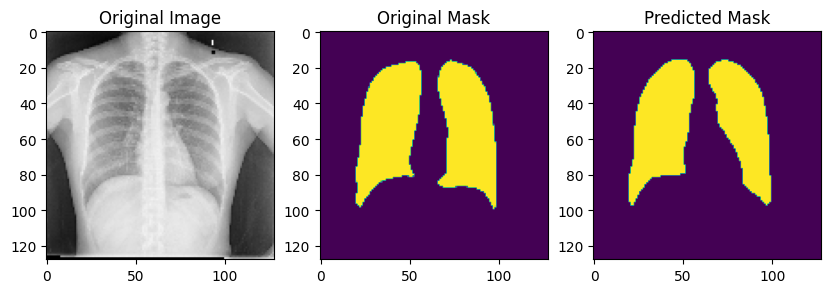

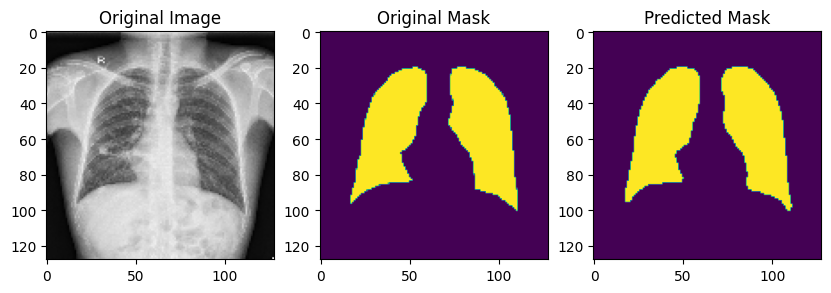

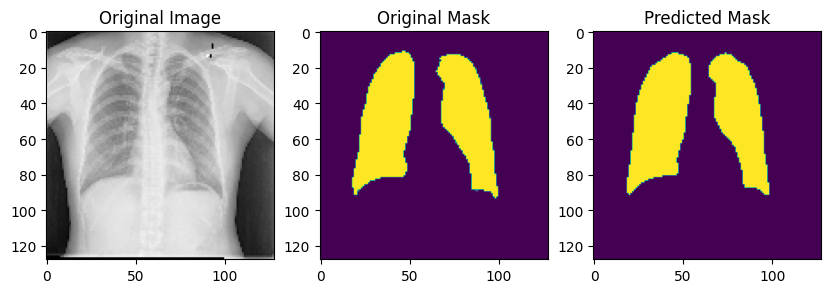

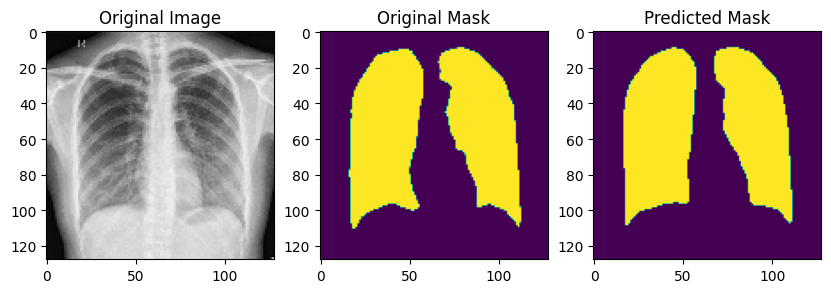

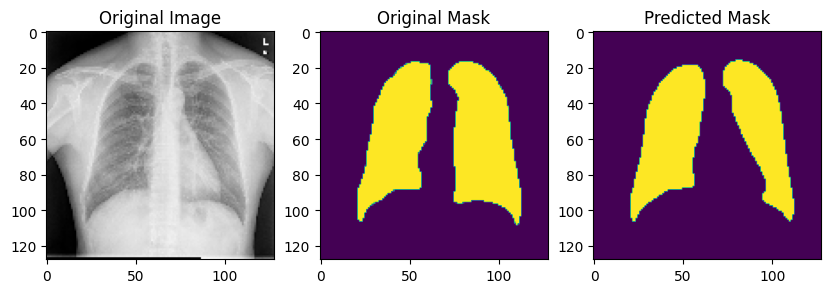

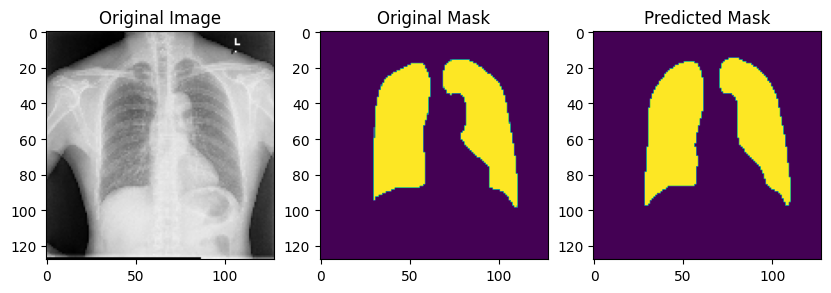

In [25]:
dice_scores = []
for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (128, 128))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (128, 128))

# normalize the image and mask to have values between 0 and 1

    test_image = test_image / 255.0
    ground_truth_test_image= ground_truth_test_image / 255.0

    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)


#by the end of this line, I have superpixeled images.
# convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)
print(test_images.shape)
print(ground_truth_test_images.shape)
# add a channel dimension to the masks
# ground_truth_test_images = np.expand_dims(ground_truth_test_images, axis=-1)


# model.load_weights("{}_full_pixel_unet_chest.best.hdf5".format('cxr_reg'))
# model.load_weights("{}_full_pixel_unet_breast.best.hdf5".format('cxr_reg'))


# Make predictions
tf.config.run_functions_eagerly(True)
predicted_masks = model.predict(
    test_images,
    batch_size=1,
    verbose=1,
    steps=None,
    callbacks=None
)

predicted_mask_array = np.array(predicted_masks)
print(predicted_mask_array.shape)

# Convert the NumPy array to uint8 format
predicted_mask_array = (predicted_mask_array * 255).astype(np.uint8)
print(predicted_mask_array.shape)

#
dst = np.empty([predicted_mask_array.shape[0],predicted_mask_array.shape[1],predicted_mask_array.shape[2]])
kernel = np.ones((5,5),np.float64)/25
# dst = predicted_mask_array

#
for i in range(predicted_mask_array.shape[0]):

        threshold_value = 1
        _, dst[i] = cv2.threshold(predicted_mask_array[i], threshold_value, 255, cv2.THRESH_BINARY)
        dst[i] = np.array(dst[i])
        dst[i] = tf.convert_to_tensor(dst[i] / 255.0,dtype=predicted_masks.dtype)

print(dst.shape)

## Cast the input tensor to a double tensor
ground_truth_test_images = tf.cast(ground_truth_test_images, dtype=tf.float64)
predicted_masks = tf.cast(dst, dtype=tf.float64)
# predicted_masks = tf.cast(predicted_mask_array, dtype=tf.float64)
# Apply thresholding



precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    precision_value = precision(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)

# dice_score = dice_coef(ground_truth_test_images, dst)
# precision_val = precision(ground_truth_test_images, dst)
# sensitivity_val = sensitivity(ground_truth_test_images, dst)
# iou_val = iou(ground_truth_test_images, dst)
# print(type(dst))

print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)

n =35 # number of images to show
for i in range(n):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i])
    ax[1].set_title('Original Mask')
    ax[2].imshow(dst[i])
    ax[2].set_title('Predicted Mask')
    plt.show()

In [40]:
# n = 35  # Number of images to show
# 
# for i in range(n):
#     # Assuming test_images, ground_truth_test_images, and dst are TensorFlow tensors
#     # Convert them to numpy arrays and ensure they are scaled to 0-255 range and in uint8 format
#     original_image = np.array(test_images[i] * 255, dtype=np.uint8)
#     ground_truth_mask = np.array(ground_truth_test_images[i] * 255, dtype=np.uint8)
#     predicted_mask = np.array(dst[i] * 255, dtype=np.uint8)
# 
#     # Ensure all images are in the correct format for concatenation
#     if len(ground_truth_mask.shape) == 2:  # Grayscale mask
#         ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_GRAY2BGR)
#     if len(predicted_mask.shape) == 2:  # Grayscale predicted mask
#         predicted_mask = cv2.cvtColor(predicted_mask, cv2.COLOR_GRAY2BGR)
# 
#     # Concatenate images for comparison
#     concatenated_image = np.hstack((original_image, ground_truth_mask, predicted_mask))
# 
#     # Display the concatenated image
#     cv2.imshow('Original Image | Original Mask | Predicted Mask', concatenated_image)
#     cv2.waitKey(500)  # Wait for 500 ms
# 
#     # Save the concatenated image
#     save_path = f"comparison_{i}.png"  # Define the save path and filename
#     cv2.imwrite(save_path, concatenated_image)
# 
# cv2.destroyAllWindows()  # Close all OpenCV windows

In [41]:
# Define the base directory where you want to save the images
base_save_path = "/home/somayeh/PycharmProjects/superpixel_segmentation/result_images/"

# Subdirectories for each image type
original_images_dir = os.path.join(base_save_path, "original_images")
original_masks_dir = os.path.join(base_save_path, "original_masks")
predicted_masks_dir = os.path.join(base_save_path, "predicted_masks")

# Create the directories if they do not exist
os.makedirs(original_images_dir, exist_ok=True)
os.makedirs(original_masks_dir, exist_ok=True)
os.makedirs(predicted_masks_dir, exist_ok=True)

In [42]:
n = 35  # Number of images to show

for i in range(n):
    # Convert TensorFlow tensors to numpy arrays and ensure they are scaled to 0-255 range and in uint8 format
    original_image = np.array(test_images[i] * 255, dtype=np.uint8)
    ground_truth_mask = np.array(ground_truth_test_images[i] * 255, dtype=np.uint8)
    predicted_mask = np.array(dst[i] * 255, dtype=np.uint8)

    # Ensure masks are in 3-channel format if original image is in color
    if len(ground_truth_mask.shape) == 2:
        ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_GRAY2BGR)
    if len(predicted_mask.shape) == 2:
        predicted_mask = cv2.cvtColor(predicted_mask, cv2.COLOR_GRAY2BGR)

    # # Display original image
    # cv2.imshow('Original Image', original_image)
    # cv2.waitKey(0)  # Wait for key press to continue

    # # Display original mask
    # cv2.imshow('Original Mask', ground_truth_mask)
    # cv2.waitKey(0)  # Wait for key press to continue

    # Display predicted mask
    # cv2.imshow('Predicted Mask', predicted_mask)
    # cv2.waitKey(0)  # Wait for key press to continue

    # # Optionally, save images if needed
    # cv2.imwrite(f"original_image_{i}.png", original_image)
    # cv2.imwrite(f"ground_truth_mask_{i}.png", ground_truth_mask)
    # cv2.imwrite(f"predicted_mask_{i}.png", predicted_mask)
    
    # Save the images with their respective paths
    cv2.imwrite(os.path.join(original_images_dir, f"original_image_{i}.png"), original_image)
    cv2.imwrite(os.path.join(original_masks_dir, f"ground_truth_mask_{i}.png"), ground_truth_mask)
    cv2.imwrite(os.path.join(predicted_masks_dir, f"predicted_mask_{i}.png"), predicted_mask)

# cv2.destroyAllWindows()  # Close all OpenCV windows after displaying all images